## Establishing connection to SQL database

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd

conn = sqlite3.connect('capstone2.db')

### Functions ###
import re
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [39]:
conn.close()

## Google Tweet Table

In [2]:
google_tweets = pd.read_sql_query('SELECT * FROM google_tweets;',  parse_dates = ['created_at'], con = conn)
google_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89728 entries, 0 to 89727
Data columns (total 7 columns):
created_at        89728 non-null datetime64[ns]
tweet             89728 non-null object
follower_count    89728 non-null int64
neg_sent          89728 non-null float64
neu_sent          89728 non-null float64
pos_sent          89728 non-null float64
compound_sent     89728 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 4.8+ MB


In [4]:
google_tweets.describe()

,follower_count,neg_sent,neu_sent,pos_sent,compound_sent
count,7.996800e+04,79968.000000,79968.000000,79968.000000,79968.000000
mean,1.158624e+04,0.059151,0.807446,0.133360,0.171626
std,2.644265e+05,0.110598,0.171896,0.154589,0.453583
min,0.000000e+00,0.000000,0.000000,0.000000,-0.988300
25%,7.400000e+01,0.000000,0.699000,0.000000,0.000000
50%,3.120000e+02,0.000000,0.826000,0.103000,0.077200
75%,1.308000e+03,0.094000,1.000000,0.226000,0.557400
max,2.802503e+07,1.000000,1.000000,1.000000,0.988000


### Diving deeper into a tweet

In [263]:
import random
random.seed(200)
index = random.randint(1,len(google_tweets))
google_tweets.iloc[[index]]

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,Company,sentiment
5979,2019-05-16,RT @Google: Toy Story is back. See the latest ...,122,0.0,1.0,0.0,0.0,GOOGL,neutral


In [264]:
google_tweets.tweet[index]

'RT @Google: Toy Story is back. See the latest Toy Story 4 trailer #WithALittleHelp from Google → https://t.co/np6XbygVvi https://t.co/Hnpmy…'

In [266]:
clean_tweet(google_tweets.tweet[index])

'RT Toy Story is back See the latest Toy Story 4 trailer WithALittleHelp from Google'

After looking into documentation, VADER understands the sentiment attached to emojis and punctuation; therefore, we need to update the tweet cleaner to only remove @user and the hyperlink. This results in a more accurate sentiment analysis.

In [272]:
pat = r'RT'
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
pat3 = r'([^0-9A-Za-z \t])'
combined_pat = r'|'.join((pat, pat1, pat2, pat3))
def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    return stripped

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    for key in list(score.keys()):
        new_key = key + '_sent'
        score[key + '_sent'] = score.pop(key)
    return(score)

In [273]:
tweet_cleaner(google_tweets.tweet[index])

'  Toy Story is back See the latest Toy Story 4 trailer WithALittleHelp from Google   '

In [248]:
sentiment_analyzer_scores(tweet_cleaner(google_tweets.tweet[index]))

{'neg_sent': 0.186,
 'neu_sent': 0.814,
 'pos_sent': 0.0,
 'compound_sent': -0.4926}

In [4]:
def neg_sent_cleaner(tweet):
    return sentiment_analyzer_scores(tweet_cleaner(tweet))['neg_sent']

def neu_sent_cleaner(tweet):
    return sentiment_analyzer_scores(tweet_cleaner(tweet))['neu_sent']

def pos_sent_cleaner(tweet):
    return sentiment_analyzer_scores(tweet_cleaner(tweet))['pos_sent']

def compound_sent_cleaner(tweet):
    return sentiment_analyzer_scores(tweet_cleaner(tweet))['compound_sent']

In [59]:
google_tweets['neg_sent'] = google_tweets.tweet.apply(neg_sent_cleaner)
google_tweets['pos_sent'] = google_tweets.tweet.apply(pos_sent_cleaner)
google_tweets['neu_sent'] = google_tweets.tweet.apply(neu_sent_cleaner)
google_tweets['compound_sent'] = google_tweets.tweet.apply(compound_sent_cleaner)

### Adding columns to classify tweet

In [6]:
def tweet_sentiment(compound):
    if compound < -0.05:
        return 'negative'
    if compound > 0.05:
        return 'positive'
    else:
        return 'neutral'

google_tweets['sentiment'] = google_tweets.compound_sent.apply(tweet_sentiment)

In [7]:
google_tweets['Company'] = 'GOOGL'

In [8]:
google_tweets.head(5)

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,CCW CHAOS (SE4 EP8) https://t.co/Sc6jFzsW7r vi...,2840,0.285,0.645,0.070,-0.7192,negative,GOOGL
1,2019-05-15,Apex Legends cause why not https://t.co/fuzrWZ...,124,0.000,1.000,0.000,0.0000,neutral,GOOGL
2,2019-05-15,Let’s keep them 👀 rolling and subscriptions🔒 i...,42,0.000,0.780,0.220,0.8625,positive,GOOGL
3,2019-05-15,Annabella and Ji Amazon Giveaway https://t.co/...,283,0.000,0.746,0.254,0.1779,positive,GOOGL
4,2019-05-15,Leather and Lace (with Don Henley) https://t.c...,145,0.000,1.000,0.000,0.0000,neutral,GOOGL


## Apply cleaning to the rest of tables in dataset

In [5]:
amazon_tweets = pd.read_sql_query('SELECT * FROM amazon_tweets;',  parse_dates = ['created_at'], con = conn)
netflix_tweets = pd.read_sql_query('SELECT * FROM netflix_tweets;',  parse_dates = ['created_at'], con = conn)
disney_tweets = pd.read_sql_query('SELECT * FROM disney_tweets;',  parse_dates = ['created_at'], con = conn)
tables = [google_tweets, amazon_tweets, netflix_tweets, disney_tweets]

In [ ]:
for table in tables:
    table['neg_sent'] = table.tweet.apply(neg_sent_cleaner)
    table['pos_sent'] = table.tweet.apply(pos_sent_cleaner)
    table['neu_sent'] = table.tweet.apply(neu_sent_cleaner)
    table['compound_sent'] = table.tweet.apply(compound_sent_cleaner)

In [9]:
for table in tables:
    table['sentiment'] = table.compound_sent.apply(tweet_sentiment)

In [10]:
amazon_tweets['Company'] = 'AMZN'
netflix_tweets['Company'] = 'NFLX'
disney_tweets['Company'] = 'DIS'

In [11]:
amazon_tweets.head(5)

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,Know what we just discovered? If #Alexa crashe...,1387,0.00,1.000,0.000,0.0000,neutral,AMZN
1,2019-05-15,"RT @HedgeMind: $AMZN As reported, Warren Buffe...",98,0.00,0.891,0.109,0.2960,positive,AMZN
2,2019-05-15,Wooden wall cuckoo #clock makes a great additi...,3874,0.00,0.691,0.309,0.7003,positive,AMZN
3,2019-05-15,RT @PaulinaUlrich: HAPPY RELEASE DAY! Timeless...,474,0.00,0.762,0.238,0.7437,positive,AMZN
4,2019-05-15,By #MikeCarrier999\nMURDER ON SUGAR ISLAND\nEx...,68295,0.27,0.447,0.283,-0.1860,negative,AMZN


In [35]:
netflix_tweets.head(5)

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,537,0.000,1.000,0.000,0.0000,neutral,NFLX
1,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,2,0.000,0.733,0.267,0.7027,positive,NFLX
2,2019-05-15,@netflix This shit got me weak💀😂 talkin thru t...,259,0.535,0.465,0.000,-0.8481,negative,NFLX
3,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,762,0.000,1.000,0.000,0.0000,neutral,NFLX
4,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,6,0.000,0.733,0.267,0.7027,positive,NFLX


In [36]:
disney_tweets.head(5)

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,RT @espn: Last time the @PelicansNBA had the N...,22657,0.091,0.785,0.124,0.2023,positive,DIS
1,2019-05-15,RT @espn: With the NCAA exploring compensation...,91,0.000,1.000,0.000,0.0000,neutral,DIS
2,2019-05-15,RT @DavidHemingson: #WhiskeyCavalier may have ...,971,0.073,0.927,0.000,-0.1280,negative,DIS
3,2019-05-15,With Joe Fixit in control and a bullet in his ...,980,0.000,0.893,0.107,0.4019,positive,DIS
4,2019-05-15,@ESPN tell your idiot broadcasters to stop eja...,0,0.268,0.732,0.000,-0.6705,negative,DIS


In [12]:
tables = [netflix_tweets, disney_tweets, amazon_tweets, google_tweets]
tweets_df = pd.concat(tables)
tweets_df.head()

,created_at,tweet,follower_count,neg_sent,neu_sent,pos_sent,compound_sent,sentiment,Company
0,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,537,0.000,1.000,0.000,0.0000,neutral,NFLX
1,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,2,0.000,0.733,0.267,0.7027,positive,NFLX
2,2019-05-15,@netflix This shit got me weak💀😂 talkin thru t...,259,0.535,0.465,0.000,-0.8481,negative,NFLX
3,2019-05-15,RT @MileyCyrus: Black Mirror Out June 5th @net...,762,0.000,1.000,0.000,0.0000,neutral,NFLX
4,2019-05-15,RT @LaurenGerman: Let’s all give a HUGE ROARIN...,6,0.000,0.733,0.267,0.7027,positive,NFLX


In [14]:
tweets_df.to_sql(name = 'tweets_df', con = conn, index = False)

In [40]:
import numpy as np
print('Netflix: %.2f \nDisney: %.2f \nAmazon: %.2f \nGoogle: %.2f'
      %(np.mean(netflix_tweets.groupby('created_at').count()['tweet']), 
        (np.mean(disney_tweets.groupby('created_at').count()['tweet'])),
        (np.mean(amazon_tweets.groupby('created_at').count()['tweet'])),
       (np.mean(google_tweets.groupby('created_at').count()['tweet']))))

Netflix: 2001.72 
Disney: 2450.12 
Amazon: 2490.84 
Google: 2804.00


In [48]:
conn = sqlite3.connect('capstone2.db')
pd.read_sql_query('SELECT Company, AVG(num) AS average_daily_tweets FROM (SELECT Company, created_at, COUNT(*) AS num FROM tweets_df GROUP BY Company, created_at) GROUP BY Company;', conn)

,Company,average_daily_tweets
0,AMZN,2490.84375
1,DIS,2450.12500
2,GOOGL,2804.00000
3,NFLX,2001.71875


In [49]:
conn.close()

## Stock Data Clean up

Since the stock market does not operate during weekends or holidays, there will not be data for those days. Instead, the missing data will be filled using interpolation which constructs new data points using linear methods.

### Google

In [31]:
google_stock = pd.read_sql_query('SELECT * from google_stock;', conn)

# DataFrame with all dates in between
date_range = pd.date_range(start = '2019-05-15', end = '2019-06-15')
date_range = date_range.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
dates = pd.DataFrame({'date': date_range})

from datetime import datetime
google_stock = dates.merge(google_stock, how='left', on = 'date')
google_stock['date'] = google_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
google_stock.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,1122.55,1178.30,1121.40,1170.80,2965117.0,GOOGL
1,2019-05-16,1171.84,1194.16,1168.45,1184.50,1765388.0,GOOGL
2,2019-05-17,1175.83,1186.29,1166.42,1168.78,1268050.0,GOOGL
3,2019-05-18,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-19,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
google_stock = google_stock.interpolate(method ='linear', limit_direction ='forward')
google_stock = google_stock.fillna(method = 'ffill')
google_stock.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,1122.55,1178.300000,1121.40,1170.80,2.965117e+06,GOOGL
1,2019-05-16,1171.84,1194.160000,1168.45,1184.50,1.765388e+06,GOOGL
2,2019-05-17,1175.83,1186.290000,1166.42,1168.78,1.268050e+06,GOOGL
3,2019-05-18,1168.22,1175.193333,1156.99,1160.74,1.355409e+06,GOOGL
4,2019-05-19,1160.61,1164.096667,1147.56,1152.70,1.442767e+06,GOOGL


### Amazon

In [33]:
amazon_stock = pd.read_sql_query('SELECT * from amazon_stock;', conn)
amazon_stock = dates.merge(amazon_stock, how='left', on = 'date')
amazon_stock['date'] = amazon_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
amazon_stock = amazon_stock.interpolate(method ='linear', limit_direction ='forward')
amazon_stock = amazon_stock.fillna(method = 'ffill')
amazon_stock.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,1827.950000,1874.43,1823.000000,1871.150000,4.692642e+06,AMZN
1,2019-05-16,1885.940000,1917.51,1882.290000,1907.570000,4.707822e+06,AMZN
2,2019-05-17,1893.050000,1910.53,1867.330000,1869.000000,4.736618e+06,AMZN
3,2019-05-18,1879.596667,1896.28,1856.733333,1865.656667,4.423811e+06,AMZN
4,2019-05-19,1866.143333,1882.03,1846.136667,1862.313333,4.111005e+06,AMZN


### Disney

In [34]:
disney_stock = pd.read_sql_query('SELECT * from disney_stock;', conn)
disney_stock = dates.merge(disney_stock, how='left', on = 'date')
disney_stock['date'] = disney_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
disney_stock = disney_stock.interpolate(method ='linear', limit_direction ='forward')
disney_stock = disney_stock.fillna(method = 'ffill')
disney_stock.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,132.550000,135.210000,132.04,134.680000,9.734068e+06,DIS
1,2019-05-16,135.290000,136.400000,134.81,135.500000,9.689397e+06,DIS
2,2019-05-17,134.260000,135.980000,134.03,135.040000,8.964178e+06,DIS
3,2019-05-18,134.256667,135.453333,133.77,134.663333,8.645785e+06,DIS
4,2019-05-19,134.253333,134.926667,133.51,134.286667,8.327393e+06,DIS


### Netflix

In [35]:
netflix_stock = pd.read_sql_query('SELECT * from netflix_stock;', conn)
netflix_stock = dates.merge(netflix_stock, how='left', on = 'date')
netflix_stock['date'] = netflix_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
netflix_stock = netflix_stock.interpolate(method ='linear', limit_direction ='forward')
netflix_stock = netflix_stock.fillna(method = 'ffill')
netflix_stock.head()

,date,open,high,low,close,volume,Company
0,2019-05-15,343.34,356.500000,341.390,354.990000,6.340118e+06,NFLX
1,2019-05-16,356.37,364.000000,353.935,359.310000,6.441463e+06,NFLX
2,2019-05-17,356.39,359.620000,353.785,354.450000,4.725448e+06,NFLX
3,2019-05-18,354.67,357.219333,350.990,352.336667,4.690804e+06,NFLX
4,2019-05-19,352.95,354.818667,348.195,350.223333,4.656159e+06,NFLX


In [36]:
stocks = [netflix_stock, amazon_stock, disney_stock, google_stock]
stocks_df = pd.concat(stocks)
stocks_df.to_sql(name = 'stocks_df', con = conn, index = False)

## Data Visualization

### Twitter Data

In [45]:
sentiment = pd.DataFrame({'NFLX': netflix_tweets.groupby('sentiment').count()['created_at'],
                          'DIS': disney_tweets.groupby('sentiment').count()['created_at'],
                          'AMZN': amazon_tweets.groupby('sentiment').count()['created_at'],
                          'GOOGL': google_tweets.groupby('sentiment').count()['created_at']})

In [285]:
sentiment

,NFLX,DIS,AMZN,GOOGL
sentiment,,,,
negative,9686,9558,10459,15312
neutral,15080,17350,14555,18949
positive,25571,33226,38247,35945


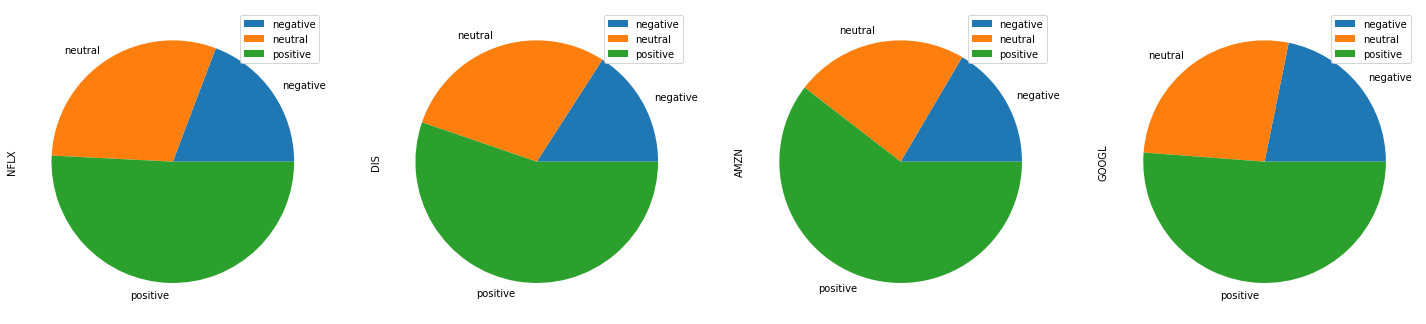

In [179]:
sentiment.plot(kind='pie', subplots=True, figsize=(25,10))
plt.show()

In [46]:
compound_sent = pd.DataFrame({'NFLX': netflix_tweets.groupby('created_at').mean()['compound_sent'],
                         'DIS': disney_tweets.groupby('created_at').mean()['compound_sent'],
                         'AMZN': amazon_tweets.groupby('created_at').mean()['compound_sent'],
                         'GOOGL': google_tweets.groupby('created_at').mean()['compound_sent']})

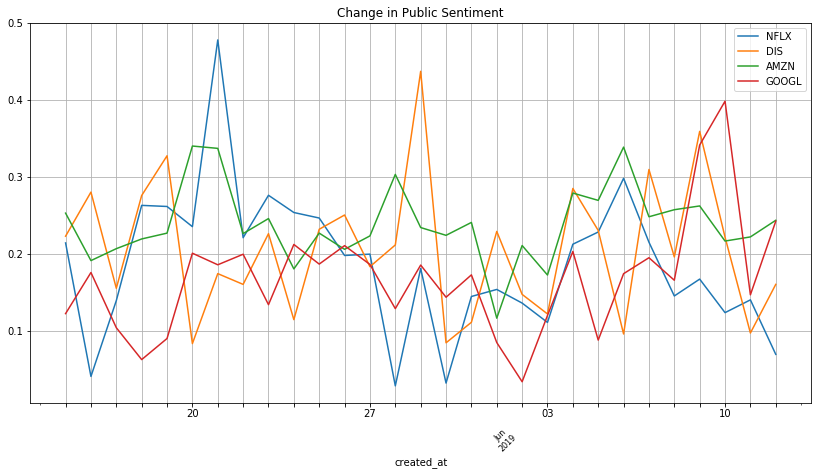

In [54]:
import matplotlib.pyplot as plt
compound_sent.plot(grid = True, figsize=(14,7), title = 'Change in Public Sentiment')
plt.xticks(compound_sent.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()

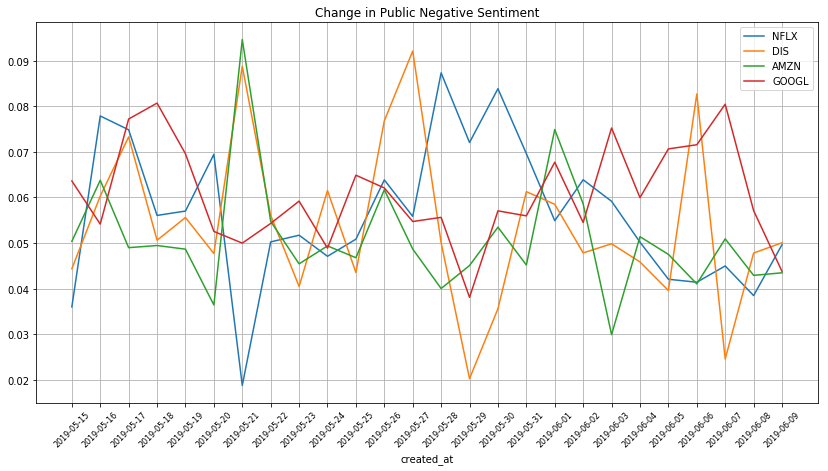

In [214]:
neg_sent = pd.DataFrame({'NFLX': netflix_tweets.groupby('created_at').mean()['neg_sent'],
                         'DIS': disney_tweets.groupby('created_at').mean()['neg_sent'],
                         'AMZN': amazon_tweets.groupby('created_at').mean()['neg_sent'],
                         'GOOGL': google_tweets.groupby('created_at').mean()['neg_sent']})
neg_sent.plot(grid = True, figsize=(14,7), title = 'Change in Public Negative Sentiment')
plt.xticks(list(range(len(neg_sent.index))), neg_sent.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()

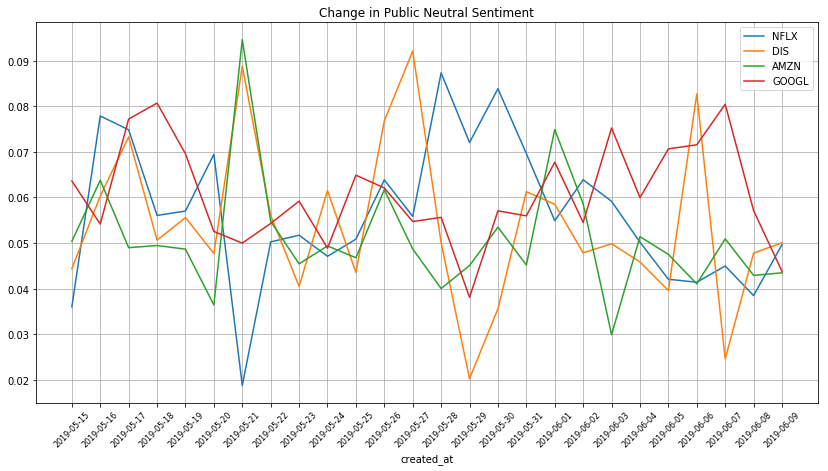

In [215]:
neu_sent = pd.DataFrame({'NFLX': netflix_tweets.groupby('created_at').mean()['neu_sent'],
                         'DIS': disney_tweets.groupby('created_at').mean()['neu_sent'],
                         'AMZN': amazon_tweets.groupby('created_at').mean()['neu_sent'],
                         'GOOGL': google_tweets.groupby('created_at').mean()['neu_sent']})
neg_sent.plot(grid = True, figsize=(14,7), title = 'Change in Public Neutral Sentiment')
plt.xticks(list(range(len(neu_sent.index))), neg_sent.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()

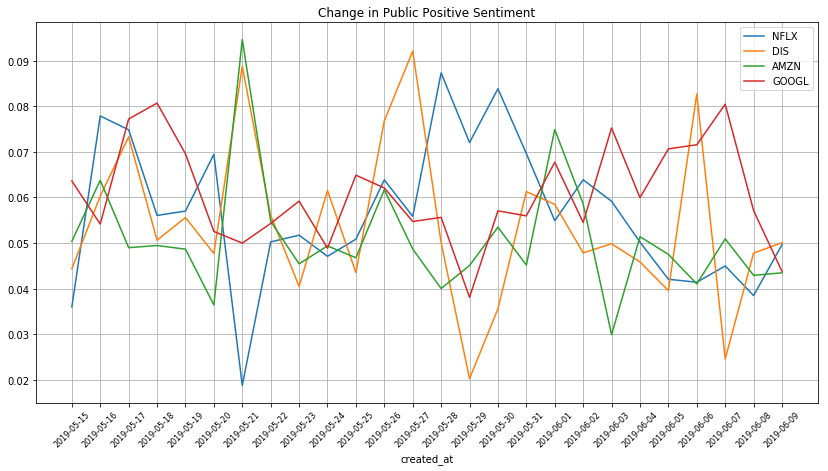

In [216]:
pos_sent = pd.DataFrame({'NFLX': netflix_tweets.groupby('created_at').mean()['pos_sent'],
                         'DIS': disney_tweets.groupby('created_at').mean()['pos_sent'],
                         'AMZN': amazon_tweets.groupby('created_at').mean()['pos_sent'],
                         'GOOGL': google_tweets.groupby('created_at').mean()['pos_sent']})
neg_sent.plot(grid = True, figsize=(14,7), title = 'Change in Public Positive Sentiment')
plt.xticks(list(range(len(pos_sent.index))), neg_sent.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()

### Stock Data

In [131]:
import matplotlib.pyplot as plt 
stock_data = [amazon_stock, netflix_stock, disney_stock]

disney_stock = dates.merge(disney_stock, how='left', on = 'date')
disney_stock['date'] = disney_stock.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
disney_stock = disney_stock.interpolate(method ='linear', limit_direction ='forward')
google_stock.set_index('date', inplace=True)

In [203]:
stocks.index

Index([2019-05-15, 2019-05-16, 2019-05-17, 2019-05-18, 2019-05-19, 2019-05-20,
       2019-05-21, 2019-05-22, 2019-05-23, 2019-05-24, 2019-05-25, 2019-05-26,
       2019-05-27, 2019-05-28, 2019-05-29, 2019-05-30, 2019-05-31, 2019-06-01,
       2019-06-02, 2019-06-03, 2019-06-04, 2019-06-05, 2019-06-06, 2019-06-07,
       2019-06-08, 2019-06-09, 2019-06-10],
      dtype='object', name='date')

In [199]:
stocks = pd.DataFrame({'NFLX': netflix_stock['open'],
                  'DIS': disney_stock['open'],
                  'AMZN': amazon_stock['open'],
                  'GOOGL': google_stock['open']})

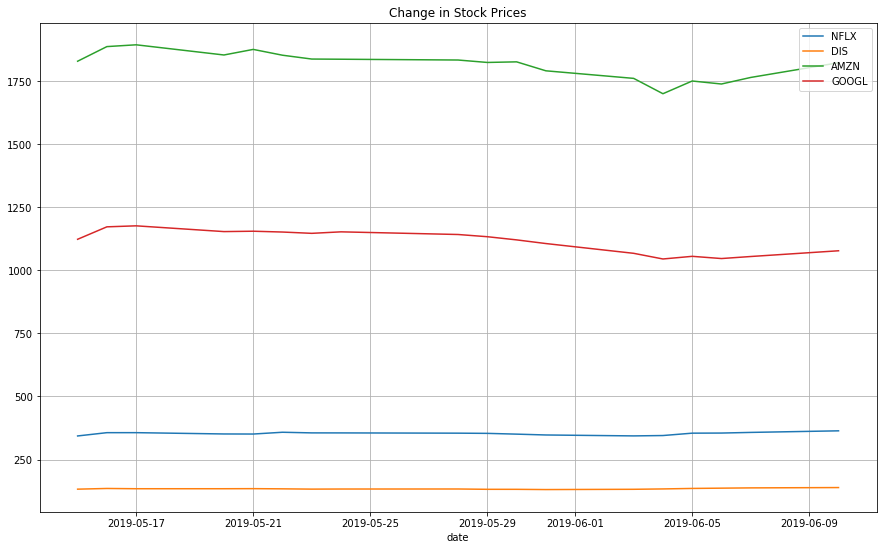

In [205]:
stocks.plot(grid = True, figsize=(15,9), title = 'Change in Stock Prices')
plt.legend(loc='upper right')
plt.show()

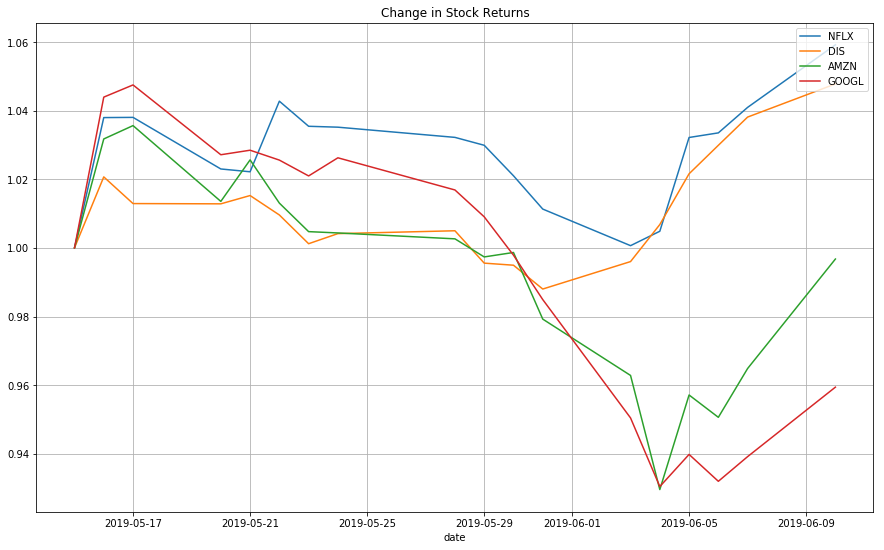

In [207]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True, figsize=(15,9), title = 'Change in Stock Returns')
plt.legend(loc='upper right')
plt.show()

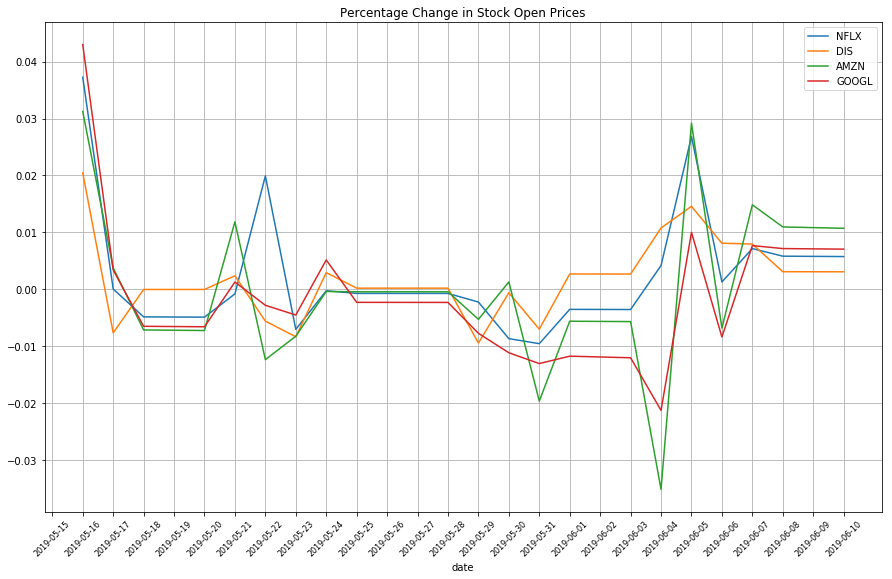

In [223]:
import numpy as np
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.plot(grid = True, figsize=(15,9), title = 'Percentage Change in Stock Open Prices')
plt.xticks(stock_change.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()

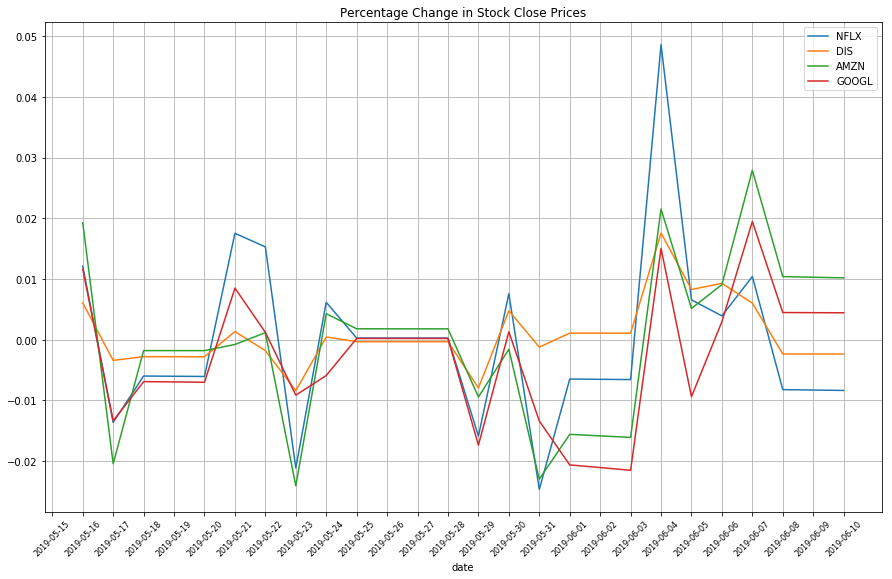

In [222]:
stocks_close = pd.DataFrame({'NFLX': netflix_stock['close'],
                  'DIS': disney_stock['close'],
                  'AMZN': amazon_stock['close'],
                  'GOOGL': google_stock['close']})
stock_change = stocks_close.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.plot(grid = True, figsize=(15,9), title = 'Percentage Change in Stock Close Prices')
plt.xticks(stock_change.index, fontsize=8, rotation = 45)
plt.legend(loc='upper right')
plt.show()